# Distribution of Rentals of BayWheel Bikes in the San Francisco Bay Area
## by Alberto Carlone

## Investigation Overview

In this presentation i want to highlight where and when, during Jaunary 2020, rentals of BayWheels bikes are made.

## Dataset Overview

The dataset consist of approximately 300,000 rentals in January 2020 done in the San Francisco Bay area. 
We have complete data on rental duration, beginning and end of rental timestamps (day and hour), beginning and end of rentals coordinates (latitude and longitude), bike ID and what type of user rented the bike (Customer or Subscriber).

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
bike = pd.read_csv('202001-baywheels-tripdata.csv')

In [3]:
bike[['start_time_date','start_time_hour']] = bike['start_time'].str.split(' ', expand = True)
bike[['end_time_date','end_time_hour']] = bike['end_time'].str.split(' ', expand = True)
bike['start_time_date'] = pd.to_datetime(bike['start_time_date'])
bike['end_time_date'] = pd.to_datetime(bike['end_time_date'])
bike['start_time_hour'] = bike['start_time_hour'].str.split(':',expand = True)[0]
bike['end_time_hour'] = bike['end_time_hour'].str.split(':',expand = True)[0]
bike['start_dayname'] = bike['start_time_date'].dt.day_name()
bike['end_dayname'] = bike['end_time_date'].dt.day_name()
bike['start_time_date'] = pd.to_datetime(bike['start_time_date']).dt.date
bike['end_time_date'] = pd.to_datetime(bike['end_time_date']).dt.date

In [4]:
ordinal_var = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_var)
bike['start_dayname'] = bike['start_dayname'].astype(ordered_var)
bike['end_dayname'] = bike['start_dayname'].astype(ordered_var)

In [5]:
bike = bike.drop(bike[bike['start_station_longitude'] == 0].index)
bike = bike.drop(bike[bike['start_station_latitude'] == 0].index)
bike = bike.drop(bike[bike['end_station_longitude'] == 0].index)
bike = bike.drop(bike[bike['end_station_latitude'] == 0].index)

In [6]:
san_francisco = bike[bike['start_station_longitude'].between(bike['start_station_longitude'].min(), -122.35, inclusive=True)]
oakland = bike[bike['start_station_longitude'].between(-122.35, -122.15, inclusive=True)]
san_jose = bike[bike['start_station_longitude'].between(-122.00, bike['start_station_longitude'].max(), inclusive=True)]

In [7]:
bike_lim = bike[bike['duration_sec'].between(0,3600)]

## Rental Distribution by Date

The number of rentals over the course of January 2020 have a distinct behaviour between working days (Monday-Friday) and weekends (Saturday-Sunday). A particular case is given by 01-01-2020, a Wednesday, that actually is an holiday (first day of the year).

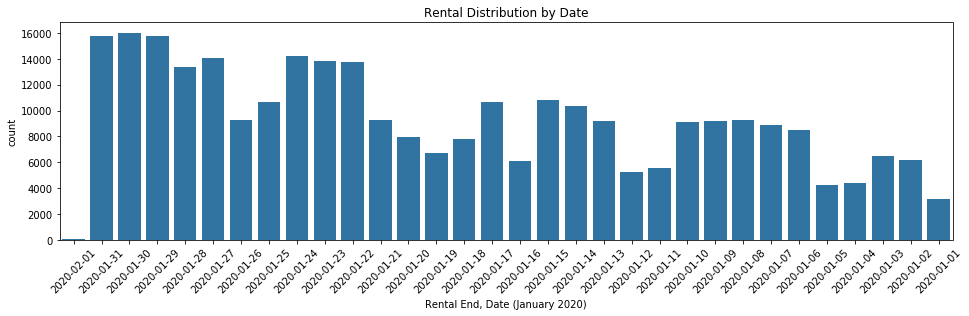

In [8]:
#Rental end by date
plt.figure(figsize = [16, 4])
plt.title('Rental Distribution by Date')
default_color = sb.color_palette()[0]
sb.countplot(data = bike, x = 'end_time_date', color = default_color)
plt.xlabel('Rental End, Date (January 2020)')
plt.xticks(rotation = 45);

## Rental Distribution by Hour

Looking at the number of rentals by the hour wheen they were done, it is clear that they are made when people usually begins or end their job, with peaks between 8:00-9:00 in the morning and 17:00-18:00 in the afternoon.

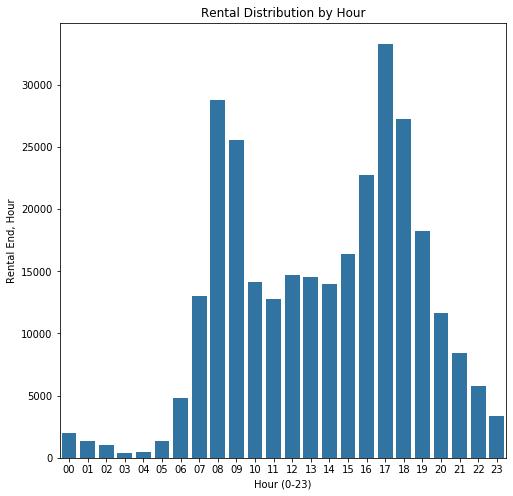

In [9]:
plt.figure(figsize = [8, 8])
plt.title('Rental Distribution by Hour')
default_color = sb.color_palette()[0]
sb.countplot(data = bike, x = 'end_time_hour', color = default_color)
plt.xlabel('Hour (0-23)')
plt.ylabel('Rental End, Hour');

## Rental Distribution by Hour Based on the Day of the Week

In the hypotesis that rentals are mainly made by workers for commuting, looking at the rentals distribution by hour for each day of the week makes it clear that the peak hours we saw previously are absent during Saturdays and Sundays where we have a more "normal" distribution of rentals based on day and night hours.

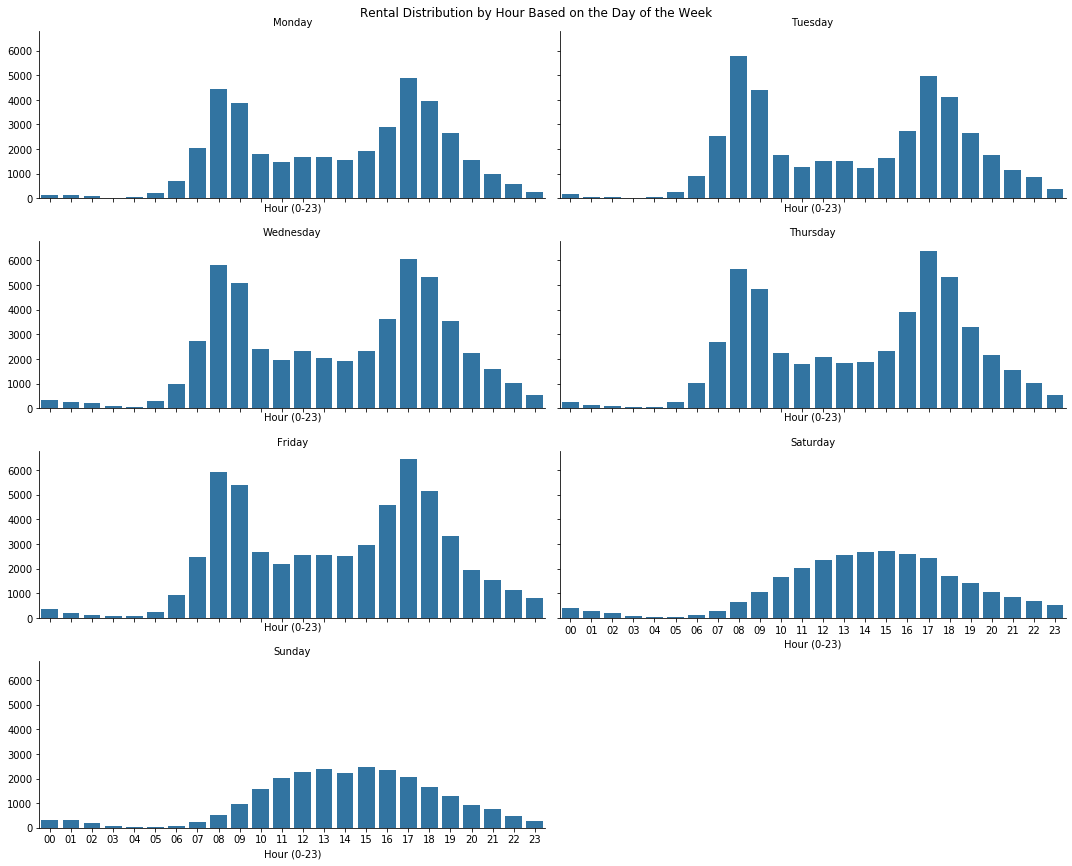

In [10]:
def countplot(x, **kwargs):
    sb.countplot(x=x, **kwargs)

grid = sb.FacetGrid(data=bike,col='end_dayname', aspect = 2.5, col_wrap = 2)
grid.map(countplot,'end_time_hour')
grid.fig.suptitle('Rental Distribution by Hour Based on the Day of the Week', y = 1)
grid.set_titles('{col_name}')
for n in range(0,7):
    grid.axes[n].set_xlabel('Hour (0-23)');

This is even clearer by looking at this heatmap.

In [11]:
dayhour_counts = bike.groupby(['end_dayname', 'end_time_hour']).size().to_frame('count')
dayhour_counts = dayhour_counts.reset_index()
dayhour_counts = dayhour_counts.pivot(index = 'end_time_hour', columns = 'end_dayname', values = 'count')

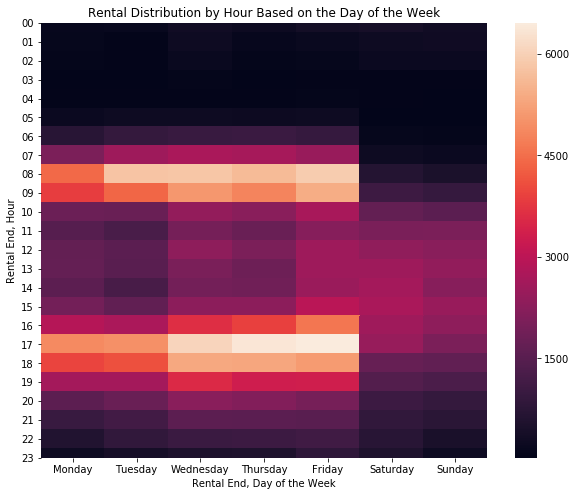

In [12]:
plt.figure(figsize = [10, 8])
plt.title('Rental Distribution by Hour Based on the Day of the Week')
sb.heatmap(dayhour_counts)
plt.yticks(rotation = 0)
plt.xlabel('Rental End, Day of the Week')
plt.ylabel('Rental End, Hour');

## Rental Distribution by Based on the City

Looking at the number of rentals made in San Francisco, Oakland and San jose we can see that more frequent in the central part of those cities (besides Oakland, where we have two "centers" given by Oakland itself and in the northern area in the direction of Berkeley) and that they follow the same behavior of the previous analysis, with a lower number of rentals during Saturdays and Sundays.

In [13]:
binsize = 0.01
def hist2dgrid(x, y, lim, bins, **kwargs):
    plt.hist2d(x, y, bins = [bins_x, bins_y], cmap = 'viridis_r', cmin = 0.5)
    plt.clim(0,lim)
    plt.xticks(rotation = 45)
    plt.colorbar()

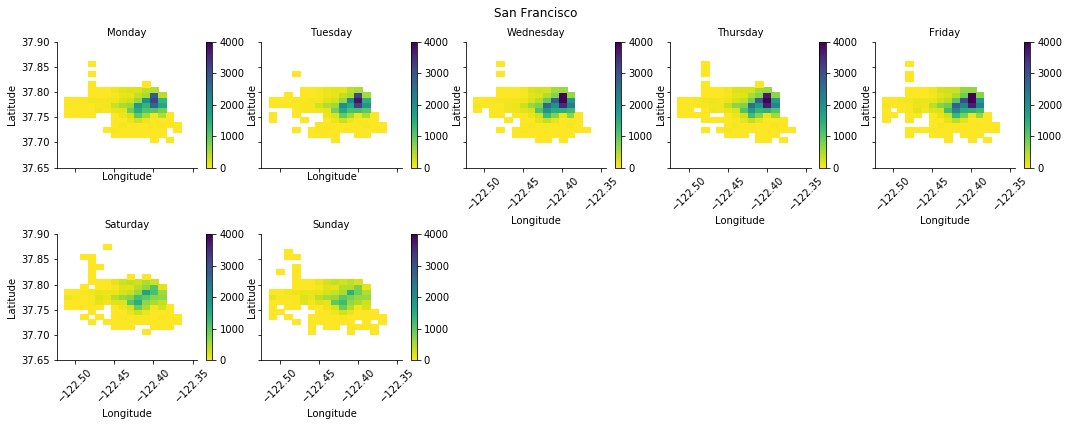

In [14]:
bins_x = np.arange(san_francisco['end_station_longitude'].min()-binsize, -122.35+binsize, binsize)
bins_y = np.arange(37.65, 37.90+binsize, binsize)
g = sb.FacetGrid(data = san_francisco, col = 'end_dayname', col_wrap = 5, height = 3,)
g.map(hist2dgrid, 'end_station_longitude', 'end_station_latitude', lim = 4000,  bins = [bins_x, bins_y] )
plt.subplots_adjust(top=0.9)
g.fig.suptitle('San Francisco')
g.set_titles('{col_name}')
for n in range(0,7):
    g.axes[n].set_xlabel('Longitude')
    g.axes[n].set_ylabel('Latitude')
plt.show()

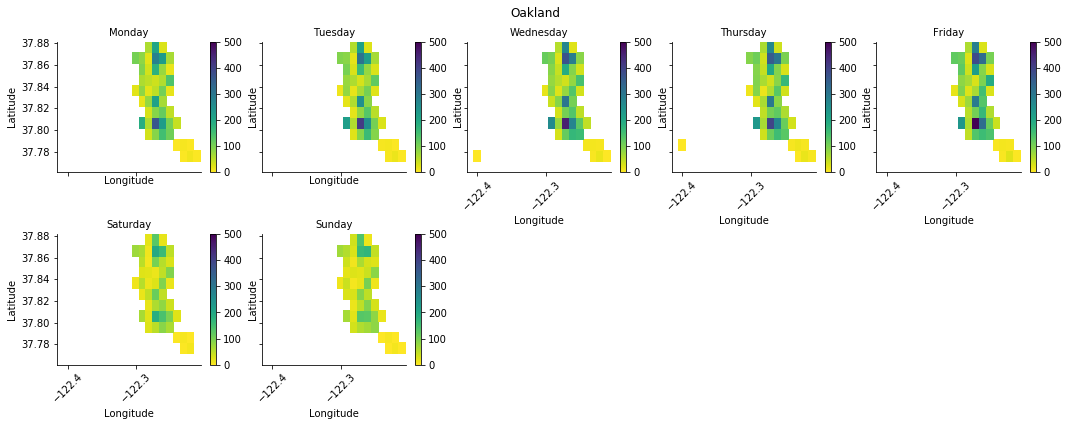

In [15]:
bins_x = np.arange(oakland['end_station_longitude'].min()-binsize, oakland['end_station_longitude'].max()+binsize, binsize)
bins_y = np.arange(oakland['end_station_latitude'].min()-binsize, oakland['end_station_latitude'].max()+binsize, binsize)
g = sb.FacetGrid(data = oakland, col = 'end_dayname', col_wrap = 5, height = 3,)
g.map(hist2dgrid, 'end_station_longitude', 'end_station_latitude', lim = 500, bins = [bins_x, bins_y] )
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Oakland')
g.set_titles('{col_name}')
for n in range(0,7):
    g.axes[n].set_xlabel('Longitude')
    g.axes[n].set_ylabel('Latitude')
plt.show()

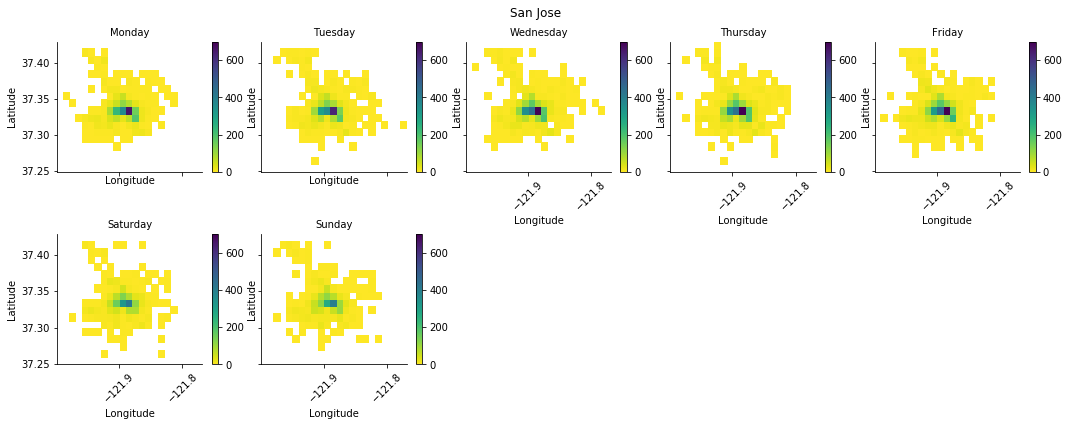

In [16]:
bins_x = np.arange(san_jose['end_station_longitude'].min()-binsize, san_jose['end_station_longitude'].max()+binsize, binsize)
bins_y = np.arange(san_jose['end_station_latitude'].min()-binsize, san_jose['end_station_latitude'].max()+binsize, binsize)
g = sb.FacetGrid(data = san_jose, col = 'end_dayname', col_wrap = 5, height = 3,)
g.map(hist2dgrid, 'end_station_longitude', 'end_station_latitude', lim = 700, bins = [bins_x, bins_y] )
plt.subplots_adjust(top=0.9)
g.fig.suptitle('San Jose')
g.set_titles('{col_name}')
for n in range(0,7):
    g.axes[n].set_xlabel('Longitude')
    g.axes[n].set_ylabel('Latitude')
plt.show()